### package

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch transformers
!pip install transformers
!pip install torch transformers
!pip install seaborn

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import transformers
from transformers import AutoTokenizer, AdamW, RobertaForSequenceClassification
import matplotlib.font_manager as fm

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('/content/train_data.csv')
test = pd.read_csv('/content/test_data.csv')
topic_dict = pd.read_csv('/content/topic_dict.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

### DATA 전처리

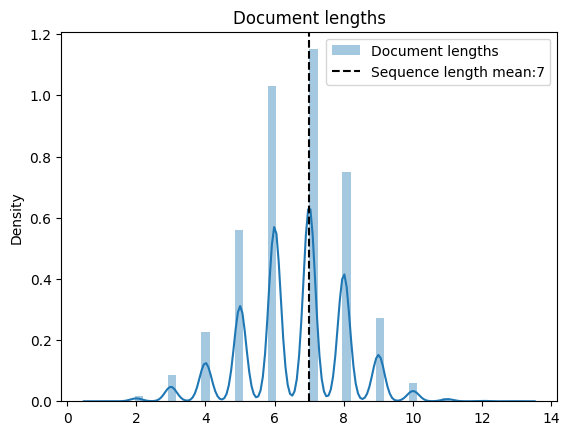

 가장 긴 문장은 13 개의 단어를, 가장 짧은 문장은 1 개의 단어를 가지고 있습니다.


In [ ]:
train['doc_len'] = train.title.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

#### class imbalanced problem


<Axes: title={'center': 'Samples per each class (Training set)'}, xlabel='topic_idx'>

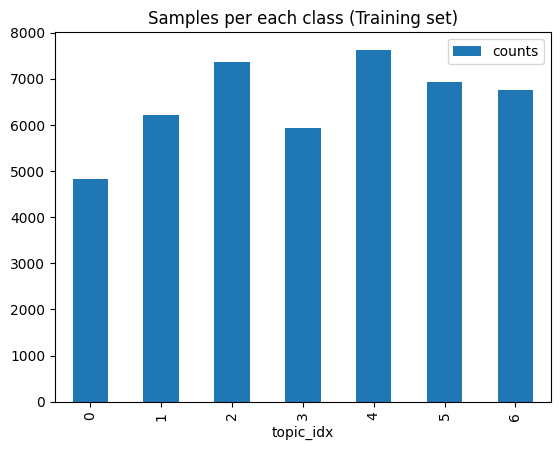

In [ ]:
train.groupby(train.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

In [ ]:
 # 훈련 세트와 테스트 세트 분리
train, val = train_test_split(train, test_size=0.2, random_state=2021)

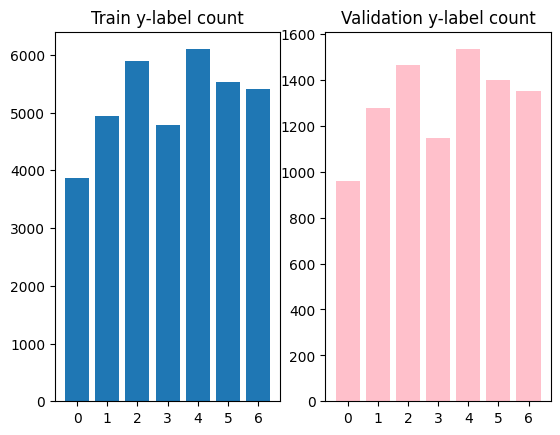

In [ ]:
train_topic_counts = train['topic_idx'].value_counts().sort_index()
val_topic_counts = val['topic_idx'].value_counts().sort_index()

plt.subplot(1, 2, 1)
plt.bar(train_topic_counts.index, train_topic_counts.values)
plt.title('Train y-label count')
plt.xticks(train_topic_counts.index)

plt.subplot(1, 2, 2)
plt.bar(val_topic_counts.index, val_topic_counts.values, color='pink')
plt.title('Validation y-label count')
plt.xticks(val_topic_counts.index)

plt.show()

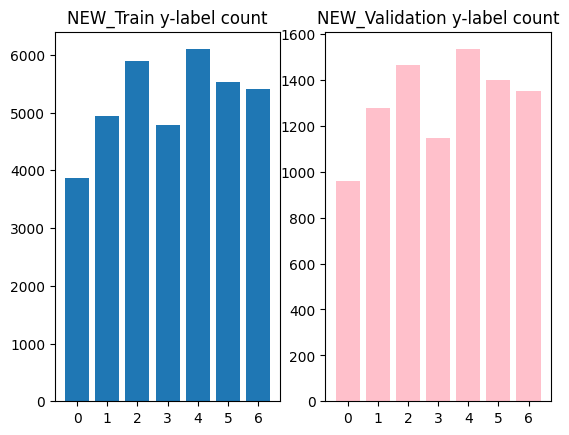

In [ ]:
NEW_train_topic_counts = train['topic_idx'].value_counts().sort_index()
NEW_val_topic_counts = val['topic_idx'].value_counts().sort_index()

plt.subplot(1, 2, 1)
plt.bar(NEW_train_topic_counts.index, NEW_train_topic_counts.values)
plt.title('NEW_Train y-label count')
plt.xticks(NEW_train_topic_counts.index)

plt.subplot(1, 2, 2)
plt.bar(NEW_val_topic_counts.index, NEW_val_topic_counts.values, color='pink')
plt.title('NEW_Validation y-label count')
plt.xticks(NEW_val_topic_counts.index)

plt.show()


### NLP- 토큰화

In [ ]:
class NTDataset(Dataset):

  def __init__(self, csv_file):
    self.dataset = csv_file
    self.tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")
    # klue/roberta-large를 이용해 토큰화 한다.
    print(self.dataset.describe())

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 1:3].values
    text = row[0] #title
    y = row[1] # topic_idx
    inputs = self.tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=15, # 방법은 적당하게 길이보고 자르는 듯
        pad_to_max_length=True, # 15에 맞게 패딩 추가
        add_special_tokens=True # 특수문자 패딩 처리하는 것 같은데,, 여기서는 특수문자를 없애지 않아서 ture로 설정한 듯
        )

    input_ids = inputs['input_ids'][0]
    #Transformers 라이브러리에서는 토큰화된 텍스트 데이터가 'input_ids'로 표현
    # [0]은 토큰화된 결과 중 첫 번째 데이터 포인트를 선택
    # ------- 여기서 0을 선택한 이유가 무엇인가요??????

    attention_mask = inputs['attention_mask'][0]
    # 어텐션 마스크: 토큰화된 시퀀스에서 실제 토큰이 있는 위치와 패딩이 채워진 위치를 구분하기 위한 값
    # 1:실ㅈㅔ 토큰, 0: 패딩위치
    # 패딩된 부분은 실제 정보가 아니기 때문에 모델이 학습하는데 방해

    return input_ids, attention_mask, y

In [ ]:
#test dataset 토큰
class NTDataset_test(Dataset):

  def __init__(self, csv_file):
    self.dataset = csv_file
    self.tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

    print(self.dataset.describe())

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 1:2].values
    #
    text = row[0]
    inputs = self.tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=15,
        pad_to_max_length=True,
        add_special_tokens=True
        )

    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    return input_ids, attention_mask

In [ ]:
train_dataset = NTDataset(train) # 모델 훈련과정
val_dataset = NTDataset(val) #모델의 하이퍼 파라미터 튜님 및 평가에 이용

test_dataset = NTDataset_test(test) # 모델의 성능 평가

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

              index     topic_idx       doc_len
count  36523.000000  36523.000000  36523.000000
mean   22786.501629      3.163732      6.584235
std    13174.530040      1.932000      1.473304
min        0.000000      0.000000      1.000000
25%    11371.000000      2.000000      6.000000
50%    22784.000000      3.000000      7.000000
75%    34188.500000      5.000000      8.000000
max    45653.000000      6.000000     13.000000
              index    topic_idx      doc_len
count   9131.000000  9131.000000  9131.000000
mean   22986.489103     3.163180     6.604096
std    13197.966636     1.936587     1.477165
min        8.000000     0.000000     2.000000
25%    11546.500000     2.000000     6.000000
50%    22999.000000     3.000000     7.000000
75%    34513.500000     5.000000     8.000000
max    45651.000000     6.000000    13.000000
              index
count   9131.000000
mean   50219.000000
std     2636.036988
min    45654.000000
25%    47936.500000
50%    50219.000000
75%    52501.5

###RoBERTa 모델

In [ ]:
device = torch.device("cuda") #파이토치 GPU 선택

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("klue/roberta-large", num_labels=7).to(device)
#.to(device): 설정된 GPU 디바이스로 모델 이동

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# epochs = 10
# 현재 val accuracy: 0.8701

epochs = 20

batch_size = 128
#모델이 한번 업데이트 될 때 마다 사용되는 데이터의 수
# 128개씩 묶어서 모델을 업데이트 > 2의 제곱이나 다른 방법등으로 최적의 배치 사이즈를 찾아야 함

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
#optimizer
# 변수를 사용하여 최적의 모델 파라미터 업데이

# AdamW 최적화 알고리즘
# 불필요한 파라미터 크기를 감소시킨다.. 학습률 조절이 중요함

# model.parameters()
# 학습 가능한 모델의 파라미터를 나타내는 함수 > opt에 전달하기 위해 사용

#lr=1e-5 > 학습률
# 작은 값을 사용하여 조금씩 가중치 업데이트

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#shuffle: 데이터를 섞을 여부 결정
# Ture: 모델이 데이터의 순서에 의존하지 않도록 하는 것

In [ ]:
# train
losses = [] #에포크마다 발생한 손실
accuracies = []
total_loss = 0.0 #전체 손실
correct = 0
total = 0

for i in range(epochs):

  model.train()

  for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
    optimizer.zero_grad() #optimizer 초기화
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    #입력 데이터와 어텐션 마스크를 모델에 전달하여 예측
    loss = F.cross_entropy(y_pred, y_batch)
    #교차 엔트로피 손실 계산: 모델의 예측이 실제 레이블과 얼마나 일치
    # 손실을 최소화 하기 위함
    loss.backward() #역전파를 통해 그라디언트 계산 > #손실을 최소화 하기 위함
    optimizer.step() # 파라미터 업데이트 적용

    total_loss += loss.item()

    _, predicted = torch.max(y_pred, 1)
    # _ 반환값 무시하면
    # 가장 높은 확률을 가지는 인덱스 값 반환
    correct += (predicted == y_batch).sum()
    total += len(y_batch)

  losses.append(total_loss)
  accuracies.append(correct.float() / total)
  print("Train Loss:", total_loss / total, "Accuracy:", correct.float() / total)

  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.004134708247287111 Accuracy: tensor(0.8257, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.003210401431730124 Accuracy: tensor(0.8633, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0027625686793213574 Accuracy: tensor(0.8823, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0024422762511425097 Accuracy: tensor(0.8958, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0021829195094373614 Accuracy: tensor(0.9068, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.001959715227881148 Accuracy: tensor(0.9165, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0017684190868992725 Accuracy: tensor(0.9246, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0016080490744382046 Accuracy: tensor(0.9316, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.001472248593272384 Accuracy: tensor(0.9374, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.001353567226332454 Accuracy: tensor(0.9426, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0012537420432208954 Accuracy: tensor(0.9469, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.001167303935200235 Accuracy: tensor(0.9505, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0010946805818768826 Accuracy: tensor(0.9536, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0010272739565517224 Accuracy: tensor(0.9565, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0009706129667355645 Accuracy: tensor(0.9589, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0009181726576465602 Accuracy: tensor(0.9611, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0008730514074922917 Accuracy: tensor(0.9631, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0008324036530880043 Accuracy: tensor(0.9648, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0007951042649776975 Accuracy: tensor(0.9664, device='cuda:0')


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0007619405511513435 Accuracy: tensor(0.9678, device='cuda:0')


In [ ]:
# validation
model.eval()
# 모델을 검증 모드로 변환
# 평가 지표 계산: 학습 중에는 계산하지 않았던 평가 지표(예: 정확도, 손실)를 계산

pred = []
correct = 0
total = 0

for input_ids_batch, attention_masks_batch, y_batch in tqdm(val_loader):
  y_batch = y_batch.to(device)
  y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
  _, predicted = torch.max(y_pred, 1)
  pred.append(predicted)
  correct += (predicted == y_batch).sum()
  total += len(y_batch)

print("val accuracy:", correct.float() / total)

  0%|          | 0/72 [00:00<?, ?it/s]

val accuracy: tensor(0.8768, device='cuda:0')


### **새로운 헤드라인을 입력했을때, 카테고리를 분류시켜주는 코드**

In [ ]:
import torch
from transformers import AutoTokenizer

#토크나이저 가져오기
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

def predict_topic(model, tokenizer, headline):
    #전처리 가져오기
    inputs = tokenizer(headline, return_tensors='pt', truncation=True, max_length= 128 , pad_to_max_length=True, add_special_tokens=True)

    with torch.no_grad():
        model.eval()
        inputs = {key: value.to(model.device) for key, value in inputs.items()}
        output = model(**inputs)

    # 확률
    probabilities = torch.nn.functional.softmax(output.logits, dim=1)[0]
    # argmax로 추출
    predicted_topic_idx = torch.argmax(probabilities).item()

    # 카테고리
    topic_dict = {
        0: 'IT과학',
        1: '경제',
        2: '사회',
        3: '생활문화',
        4: '세계',
        5: '스포츠',
        6: '정치'
    }
    predicted_topic = topic_dict.get(predicted_topic_idx, 'Unknown')

    return predicted_topic_idx, predicted_topic

news_headline = input("news headline을 입력하세요: ")

model.to('cuda:0')

topic_idx, topic = predict_topic(model, tokenizer, news_headline)

print(f"Predicted Topic: {topic}")

news headline을 입력하세요: 윤석열 대통령 하야
Predicted Topic: 정치


In [ ]:
# Save the model
model.save_pretrained("/content/model")

from google.colab import files

# 모델 디렉터리를 압축 파일로 만들기
!zip -r /content/model.zip /content/model

# 압축 파일 다운로드
#files.download("/content/model.zip")


In [ ]:
!pip install joblib

In [ ]:
import joblib
import os

directory = '/content/drive/MyDrive/model'
if not os.path.exists(directory):
    os.makedirs(directory)

# 모델 및 기타 객체 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/model/model_state_dict.pth')
torch.save(optimizer.state_dict(), '/content/drive/MyDrive/model/optimizer_state_dict.pth')
joblib.dump({
    'epochs': epochs,
    'losses': losses,
    'accuracies': accuracies
}, '/content/drive/MyDrive/model/training_info.pkl')


['/content/drive/MyDrive/model/training_info.pkl']

In [ ]:
import torch
from transformers import AutoTokenizer

def predict_topic(model, tokenizer, headline):
    #전처리 가져오기
    inputs = tokenizer(headline, return_tensors='pt', truncation=True, max_length= 128 , pad_to_max_length=True, add_special_tokens=True)

    with torch.no_grad():
        model.eval()
        inputs = {key: value.to(model.device) for key, value in inputs.items()}
        output = model(**inputs)

    # 확률
    probabilities = torch.nn.functional.softmax(output.logits, dim=1)[0]
    # argmax로 추출
    predicted_topic_idx = torch.argmax(probabilities).item()

    # 카테고리
    topic_dict = {
        0: 'IT과학',
        1: '경제',
        2: '사회',
        3: '생활문화',
        4: '세계',
        5: '스포츠',
        6: '정치'
    }
    predicted_topic = topic_dict.get(predicted_topic_idx, 'Unknown')

    return predicted_topic_idx, predicted_topic

news_headline = input("news headline을 입력하세요: ")

model.to('cuda:0')

topic_idx, topic = predict_topic(model, tokenizer, news_headline)

print(f"Predicted Topic: {topic}")

news headline을 입력하세요: 복지 사각지대 보완하자
Predicted Topic: 사회
